# EnKF: summary
This code is written to apply EnKF using the machine learned ROM model with different observations. observations include: the eassy just add noise to ROM, QDYN data with liinear observation model and finally a nonlinear observation.
## To do:
* implement noise (done)
* implement uniform time stepping and have a forward model (done)
* generate some observation (done)

* implement linear observational operator (done)
* Function to find Kalman gain (done)
* double check everything before applying the nonlinear observation operator (done)
* implement nonlinear observational operator (in progress)
* Machine learning the analysis step.
* generate some data using aging and slip law.
* find the best model noise, update the noise function, run a big simulation.

* after the break: (Read the codes and understand what you have done)
* you need a seperate file (I guess) to find the model error. (done)
* you might need to write a condition to interrupt the program if the inversion has some bad results to stop it.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from ProcessFunctions import find_Aisv2,Find_a_i,find_Aisv2_onlyv,Find_T_X_tau_without_p_input
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.interpolate import interp1d
import seaborn as sns 
from scipy import integrate
import scipy

# Loading POD modes
data_dir="/central/groups/astuart/hkaveh/Data/LearnROM/MainSimulation_Tf600Nt=5PODonlyonV.npz"
PODmodes=np.load(data_dir)
U_v=PODmodes['U']
S_v=PODmodes['S']
VT_v=PODmodes['VT']
q_bar_v=PODmodes['q_bar']
Sigma_v=np.diagonal(S_v)
Nt2=VT_v.shape[0]
Lambda_v=Sigma_v**2/Nt2 # Covariance matrix


data_dir="/central/groups/astuart/hkaveh/Data/LearnROM/MainSimulation_Tf600Nt=5PODonlyontheta.npz"
PODmodes=np.load(data_dir)
U_theta=PODmodes['U']
S_theta=PODmodes['S']
VT_theta=PODmodes['VT']
q_bar_theta=PODmodes['q_bar']
Sigma_theta=np.diagonal(S_theta)
Nt2=VT_theta.shape[0]
Lambda_theta=Sigma_theta**2/Nt2 # Covariance matrix
N_m_load=30
phi=U_v[:,:N_m_load]    # This contains the eigen mode for velocity


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
N_m_v_list=[20,25,30]
N_m_theta_list=[20,25,30]
index=2
N_m_theta=N_m_theta_list[index]
N_m_v=N_m_v_list[index]

dt=5*24*3600 # time step
Lambda=np.append(Lambda_v[:N_m_v],Lambda_theta[:N_m_theta]) # Lambda is the covariance matrix
Lambda=np.diag(Lambda)
Gamma=np.diag(Lambda_v[:N_m_v])
gamma_ratio=0.0001*5 # variance of the observation noise is multiplied by the value

max_X_list=np.array([657.090180396257, 657.090180396257,698.3903391568679])    # For version 2024.11
max_y_list=np.array([28.19128123215918,28.19128123215918,25.87581902121011])  # For version 2024.11

# max_y_list=np.array([26.351065203181317,26.351065203181317,26.351065203181317]) # for model version 0
# max_y_list=np.array([13.638293616464068,13.638293616464068,13.638293616464068])  # For version 96
max_X=max_X_list[index]
max_y=max_y_list[index]



N_m=N_m_theta+N_m_v
max_X_dt=657.0901803962595 # these are the same for different list_Nv[i]
max_Y_dt=7.330702809730826 # these are the same for different list_Nv[i]

t_yr=365*24*3600           # number of seconds in a year
Nx=256
Nz=32
L_thresh=1e3
L=320e3
L_fault=L
W=50e3
x_ox=np.linspace(-L/2,L/2,Nx)
z_ox=np.linspace(0,W,Nz)
Area=320e3*50e3
mu=30e9
V_thresh=(5e-8)
size_x=256
size_y=32
size=int(size_x*size_y)
L_element_x=L/size_x
L_element_y=W/size_y
sigma_kernel=2000 # in meters
sigma_x=sigma_kernel/L_element_x # in number of elements
sigma_y=sigma_kernel/L_element_y # in number of elements
Obs_linear=0
inflation=1  # inflection of the model noise covariance matrix

In [4]:
print(L_element_x)
print(sigma_x)
print(L_element_y)
print(sigma_y)

1250.0
1.6
1562.5
1.28


# Noise
I start with noise because it is the easiest. What do you need to make noise? probably the standard deviation of the POD modes. Some assumption on the ratio of the noise. Ok, how can you get the standard deviation? I think I can just import it.

In [5]:
# defining the model noise as xi \in R^n which is a normal distribution with mean 0 and std proportional to Lambda,
# We take the covarinace matrix of the model noise (remember covariance as the unit standard deviation squared)
# Here covariance matrix is Sigma

def xi_call2(Lambda,xi_ratio,m):
    xi=np.random.multivariate_normal(np.zeros(Lambda.shape[0]),xi_ratio*Lambda,m)
    return xi.T

def xi_call(N_m,cov,m):
    xi=np.random.multivariate_normal(np.zeros(N_m),cov,m)
    return xi.T

In [6]:
Gamma.shape

(30, 30)

In [7]:
# Checking the distribution of the model noise
# m=10000
# xi=xi_call(40,Lambda,m)
# sns.histplot(xi[0,:],kde=True)
# plt.show()
# sns.histplot(xi[19,:],kde=True)
# plt.show()
# sns.histplot(xi[20,:],kde=True)
# plt.show()
# sns.histplot(xi[39,:],kde=True)

In [8]:
# defining the observation noise as eta \in R^d which is a normal distribution with mean 0 and std proportional to Lambda_y,
def eta_call(Gamma,gamma_ratio,m):
    eta=np.random.multivariate_normal(np.zeros(Gamma.shape[0]),gamma_ratio*Gamma,m)
    return eta.T

In [9]:
# m=10000
# eta=eta_call(Gamma,gamma_ratio,m)
# sns.histplot(eta[0,:],kde=True)
# plt.show()
# sns.histplot(eta[19,:],kde=True)


In [10]:
eta_call(Gamma,gamma_ratio,5)

array([[-3.08648483e-01,  6.54117660e-01, -1.77319288e+00,
        -9.39779184e-02, -7.00083945e-01],
       [ 1.70529992e+00,  1.87403240e-01, -1.40066825e+00,
         1.01730819e+00, -6.20827002e-02],
       [-3.73646820e-01, -4.89551338e-02, -1.13186700e+00,
        -4.56682200e-01, -7.90786956e-01],
       [-4.53757186e-01,  8.46361205e-02, -1.78770944e-03,
         3.18111652e-01, -8.79814678e-01],
       [ 1.23512328e-01, -5.43154167e-02,  1.04120085e-01,
         9.91402458e-01,  1.52344978e+00],
       [-2.94342613e-01, -4.91894839e-02,  5.81399862e-03,
         2.46972708e-01, -4.63645341e-01],
       [-4.24461725e-01,  2.14085423e-01,  6.35280712e-03,
         2.24403560e-03,  1.28293145e-01],
       [ 1.73281002e-01, -1.12209406e-01, -4.37241963e-01,
         6.91510427e-01,  1.55307137e-01],
       [-4.02108211e-01, -7.87784574e-01,  1.89665949e-01,
        -9.15463701e-02, -1.60699064e-01],
       [ 4.89246432e-01,  6.43059689e-02,  2.11398655e-02,
         6.21585185e-02

# Uniform time stepping discrete map

To do:

* Import and load the model snapshot and timestep.
* pick an initial condition. randomly. I tested the code with a few initial conditiions and checked the invariant measure and they look similar to the invariant measure of the system.
* This is what I am going to do. In each iteration, I find the forecast, then multiply it by max_X to get alpha without scales. Then I find the vmax from the unscaled data. Then I divide alpha by `max_X_dt` and concatinate with vmax to have the input for the machine learning model of dt.  Then I run it through the ML model for time stepping and then to get the actual dt, I need to multiply the output by max_Y_dt.
* Write the thing in a function. in the form: $\alpha(t_{n+1})=f(\alpha(t_n),t_n)$

In [11]:
# import the model from the code MLmodel8postprocess.ipynb
# %% Defining model (g_1)
class Forwardmap(nn.Module):
    def __init__(self,N_m):
        super().__init__()
        self.hidden1=nn.Linear(N_m,2*N_m)
        self.act1=nn.Tanh()
        self.hidden2=nn.Linear(2*N_m,4*N_m)
        self.act2=nn.Tanh()
        self.hidden3=nn.Linear(4*N_m,4*N_m)
        self.act3=nn.Tanh()
        self.hidden4=nn.Linear(4*N_m,2*N_m)
        self.act4=nn.Tanh()
        self.output=nn.Linear(2*N_m,N_m)

    def forward(self,x):
        x=self.act1(self.hidden1(x))
        x=self.act2(self.hidden2(x))
        x=self.act3(self.hidden3(x))
        x=self.act4(self.hidden4(x))
        x=(self.output(x))
        return x
    
version=2024.11
model=Forwardmap(N_m_v+N_m_theta)
model.load_state_dict(torch.load( "/central/groups/astuart/hkaveh/Data/LearnROM/ROM_POD_separate_onV_theta"+str(version)+"N_m_v"+str(N_m_v)+"N_m_theta"+str(N_m_theta)+".pt"))
model.eval()
model=model.to(device)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [12]:
# The reduced order model for v is already loaded
# lets load the model for dt
# Loading the pytorch ML model
# we had saved the model with the following code:
version_dt=2024.11
#torch.save(model.state_dict(), "/central/groups/astuart/hkaveh/Data/LearnROM/ROMdt_POD_separate_onV_theta"+str(version)+"N_m_v"+str(N_m_v)+".pt")# now we want to load it
# lets code the forward model
# %% Defining model
class Forwardmapdt(nn.Module):
    def __init__(self,N_m):
        super().__init__()
        self.hidden1=nn.Linear(N_m+1,2*N_m)
        self.act1=nn.Tanh()
        self.hidden2=nn.Linear(2*N_m,4*N_m)
        self.act2=nn.Tanh()
        self.hidden3=nn.Linear(4*N_m,4*N_m)
        self.act3=nn.Tanh()
        self.hidden4=nn.Linear(4*N_m,2*N_m)
        self.act4=nn.Tanh()
        self.output=nn.Linear(2*N_m,1)

    def forward(self,x):
        x=self.act1(self.hidden1(x))
        x=self.act2(self.hidden2(x))
        x=self.act3(self.hidden3(x))
        x=self.act4(self.hidden4(x))
        x=(self.output(x))
        return x
    
modeldt=Forwardmapdt(N_m_v)
modeldt.load_state_dict( torch.load("/central/groups/astuart/hkaveh/Data/LearnROM/ROMdt_POD_separate_onV_theta"+str(version_dt)+"N_m_v"+str(N_m_v)+".pt"))
modeldt.eval()
modeldt=modeldt.to(device)


In [13]:
def find_logvmax(alpha,phi_v):
    v=np.dot(phi_v,alpha)[:, np.newaxis]+q_bar_v # v and theta
    logvmax=np.max(v)
    return logvmax

In [14]:
params_f=[max_X,max_y,max_X_dt,max_Y_dt,N_m_v,phi,N_m]


In [15]:
N_m

60

In [16]:
# This function is written to find the next time step in the Kalman filter algorithm and is the forward model
def f(alpha_k,dt,params_f):
    # alpha_k is the state at time k
    # alpha_kp1 is the state at time k+1
    # dt is the time step (assume in seconds)
    max_X=params_f[0]
    max_y=params_f[1]
    max_X_dt=params_f[2]
    max_Y_dt=params_f[3]
    N_m_v=params_f[4]
    phi=params_f[5]
    N_m=params_f[6]
    xk=torch.tensor(alpha_k/max_X, dtype=torch.float32)
    forecast=xk.detach().cpu().numpy().reshape(N_m,1)
    time=np.array([0])
    while time[-1]<dt:
        xk=xk.to(device)
        ykp1=(model(xk))*(max_y/max_X)
        xkp1=ykp1+xk
        xk=xkp1
        numpy_vector = xkp1.detach().cpu().numpy().reshape(N_m,1)
        x_ML=numpy_vector*max_X                             # This is the alpha that has both v and theta
        vmax=find_logvmax(x_ML[:N_m_v],phi[:,:N_m_v])       # This is the maximum of v
        x_input_dt_ML=x_ML[:N_m_v]/max_X_dt                 # This is the input for the dt model (except vmax)
        x_input_dt_ML=np.append(x_input_dt_ML,vmax)         # This is the input for the dt model
        x_input_dt_ML=torch.tensor(x_input_dt_ML, dtype=torch.float32) # This is the input for the dt model
        x_input_dt_ML=x_input_dt_ML.to(device)
        dt_pred=modeldt(x_input_dt_ML)                      # This is the prediction for the time step
        dt_pred=10**(dt_pred.detach().cpu().numpy()*max_Y_dt)     # This is the prediction for the time step
        time=np.append(time,dt_pred+time[-1])                        # This is the time vector
        forecast = np.hstack([forecast, numpy_vector])      # This is the forecasted alpha (not scaled though)
    # applying linear interpolation to find forecast at time dt, using only the last two points
    f2 = interp1d([time[-2],time[-1]], forecast[:,-2:],axis=1)
    alpha_kp1=f2(dt).reshape(N_m,1)
    # Removing the last coulmn of forecast becasue it is for the time when t > dt
    forecast=forecast[:,:-1]
    time[-1]=dt
    # Then appending it to the forecast
    forecast = np.concatenate((forecast, alpha_kp1),axis=1)*max_X
    return forecast,time


## Checking the forwawrd model

## Running the forward model for a long time (to check the statistics):
To plot (the scaling and invariant measure) you can uncomment the following cells.

In [17]:
# # This cell runs the program for up to time t_test
# t_test=45*24*3600*365
# size_x=256
# size_y=32
# size=U_v.shape[0]
# alpha_k=xi_call(40,Lambda,1).T
# forecast,time=f(alpha_k,t_test,params_f)

In [18]:
# # This cell calculate the things we need for finding the scaling laws.
# vmaxs=[]
# V_ox_ROM=np.empty((forecast.shape[1],size_y,size_x))
# t_ox_ROM=np.ones((forecast.shape[1],size_y,size_x))
# U_ROM=U_v[:,0:N_m_v]

# for j in range(forecast.shape[1]):
#     V_snapshot = U_ROM @ (forecast[:N_m_v, j]) + q_bar_v.reshape(size,)
#     V_snapshot = V_snapshot[:size_x * size_y].reshape(size_y, size_x)
#     V_ox_ROM[j,:,:]=10**(V_snapshot)
#     t_ox_ROM[j,:,:]=time[j]*np.ones((size_y,size_x))
#     vmaxs.append(np.max(V_snapshot))
# TimeStarts_ML,TimeEnds_ML,rectangles_ML,Mags_ML=Find_T_X_tau_without_p_input(V_ox_ROM,t_ox_ROM,V_thresh,L_thresh,t_yr,x_ox,z_ox,L_fault,mu)
 

## Loading QDYN simulation and scalings

In [19]:
# def FindMwupdated(V_full,t_full,V_thresh):
#     flag=0
#     V_max=np.max(V_full,axis=(1,2))
#     Mw=np.array([])
#     T1=np.array([]) # it is the time of when the earthquakes nucleate
#     T2=np.array([]) # it is the time of when the earthquake stops
#     PotRate=np.sum(V_full,axis=(1,2))*Area/Nx/Nz

#     for i in range(V_max.size):
        
#         if flag==0 and V_max[i]>V_thresh: # an event has started
#             flag=1
#             index1=i
#             T1=np.append(T1,t_full[i])
#         if flag==1 and V_max[i]<V_thresh: # the event has stopped
#             flag=0
#             index2=i
#             IntPotRate=integrate.cumtrapz(PotRate[index1:index2+1],t_full[index1:index2+1])
#             Integration=IntPotRate[-1]
#             M0=Integration*mu
#             Mw=np.append(Mw,(2/3)*np.log10(M0)-6)
#             T2=np.append(T2,t_full[i])
#     return Mw,T1,T2

In [20]:
# # I need to load some of the already run models to check the scaling, after checking you can commentout this cell
# # Loading the data from the simulation
# # Loading data from "/central/groups/astuart/hkaveh/Data/LearnROM/"
# Tf = 250 # each initial condition is simulated for 250 years
# Nt=5     # it is recorded every Nt time stes

# N_m_load=30
# coeff=2 # How the inital conditions are from the chaotic attractor
# N_cut=2000
# filter_ratio=0.4 # removing 40 percent of the data
# # loading time series:


# Mws_v2=np.array([])
# T1s_v2=np.array([])
# T2s_v2=np.array([])
# rectangles_all=np.array([])

# findscaling=1
# X_full=np.empty((1,N_m_load*2))

# for number in range(10):
#     data_dir="/central/groups/astuart/hkaveh/Data/LearnROM/SampleSimulation_Tf"+str(Tf)+"Nt="+str(Nt)+"N_m"+str(N_m_load)+"coeff"+str(coeff)+"number"+str(number)+".npz"
#     data_smaple=np.load(data_dir)
#     V_ox=data_smaple['array1']
#     theta_ox=data_smaple['array2']
#     t_ox=data_smaple['array3']
#     # We work we log10 of V_ox:
#     t=t_ox[:,0,0].reshape(-1,1)
#     Start_index=int(V_ox.shape[0]*filter_ratio)
    

#     if findscaling==1:

#         TimeStarts,TimeEnds,rectangles,Mags=Find_T_X_tau_without_p_input(V_ox,t_ox,V_thresh,L_thresh,t_yr,x_ox,z_ox,L_fault,mu)
#         Mws_v2=np.append(Mws_v2,Mags)
#         T1s_v2=np.append(T1s_v2,TimeStarts)
#         T2s_v2=np.append(T2s_v2,TimeEnds)
#         rectangles_all=np.append(rectangles_all,rectangles)
#     V_ox=np.log10(V_ox)
#     theta_ox=np.log10(theta_ox)
#     A_v,P_v=find_Aisv2_onlyv(U_v,V_ox,q_bar_v,N_m_load) # you dont need P in general, but I need it to check if I do everything correctly
#     A_theta,P_theta=find_Aisv2_onlyv(U_theta,theta_ox,q_bar_theta,N_m_load)
#     A=np.concatenate((A_v,A_theta),axis=1)
#     X_onesimulation=A[Start_index:-1,:] # with removig the first 20 percent of the data to remove the transient
#     X_full=np.append(X_full,X_onesimulation,axis=0)
# X_full=X_full[1:,:]

# Nrectangles=int(rectangles_all.size/4)
# rectangles_all=np.reshape(rectangles_all,(Nrectangles,4))
# Areas=W*(rectangles_all[:,3])*1000

In [21]:
# # Checking the invariant measure in the pytorch model

# fig, axs = plt.subplots(3, 5, figsize=(15, 10))

# # Flatten the axs array so that we can iterate over it easily
# axs = axs.flatten()

# # Plot the KDE plot for each column of X_full
# for i in range(15):
#     sns.kdeplot(forecast[i,:], ax=axs[i],label='ROM (n=40)')
#     sns.kdeplot(X_full[:, i], ax=axs[i],label='QDYN')
#     axs[i].set_title(r'$\alpha_{{{}}}$'.format(i+1))
#     axs[i].legend()


# # Adjust layout and show plot
# plt.tight_layout()
# plt.show()

In [22]:
# # Plotting the scaling laws:
# plt.rcParams.update({
#     'font.family': 'serif',
#     'font.serif': ['Times New Roman'],
#     'text.usetex': True,  # If you want to use LaTeX for rendering text
# })
# fig, axs = plt.subplots(1, 2, figsize=(8, 3))

# plt.rcParams.update({'font.family': 'serif', 'font.serif': 'Times New Roman','font.size': 8})
# string=str(N_m)
# axs[0].plot(10**(1.5*(Mags_ML+6)),TimeEnds_ML-TimeStarts_ML,'o',label='ROM with n='+str(string),alpha=0.2)
# Nrectangles_ML=int(rectangles_ML.size/4)
# rectangles_ML=np.reshape(rectangles_ML,(Nrectangles_ML,4))
# Areas_ML=W*(rectangles_ML[:,3])*1000
# axs[1].plot(10**(1.5*(Mags_ML+6)),Areas_ML,'o',label='ROM with n='+str(string),alpha=0.2)
# axs[0].plot(10**(1.5*(Mws_v2+6)),T2s_v2-T1s_v2,'o',label='QDYN',color='black',alpha=0.005)  
# axs[1].plot(10**(1.5*(Mws_v2+6)),Areas,'o',label='QDYN',color='black',alpha=0.005)

# axs[0].set_xscale('log')
# axs[0].set_yscale('log')
# axs[0].legend()
# axs[0].set_title('Moment Duration Scaling Law')
# axs[0].set_xlabel(r"$\int_{t_1}^{t_2} \mu \dot{P} dt$")
# axs[0].set_ylabel(r"Duration($s$)")

# axs[1].set_xscale('log')
# axs[1].set_yscale('log')
# axs[1].legend()
# axs[1].set_title('Moment Area Scaling Law')
# axs[1].set_xlabel(r"$\int_{t_1}^{t_2} \mu \dot{P} dt$")
# axs[1].set_ylabel(r"Area ($m^2$)")
# # plot a line with slope 1/3 in log log scale
# x = np.linspace(10**(16),10**18,100)
# y = 10**(1/3*np.log10(x*1e5)) 
# y2= 10**(2/3*np.log10(x*1e-3))
# axs[0].plot(x,y,color='black')
# axs[1].plot(x,y2,color='black')
# for ax in axs:

#     leg = ax.legend()
#     # Set legend handle alpha to 1 for each legend
#     for lh in leg.legendHandles:
#         lh.set_alpha(1)

In [23]:
# now that I have checked everything, I can wrte function f for uniform time stepping


### Checking the interpolation:
we start from an initial conditon, simulate it for 7 days and then simulate with the same initial conditions for 1 day, 2 days, 3 days 4 days and 5 days, then I plot how does the system look.

In [24]:
# forecast1,time1=f(alpha_k,1*24*3600,params_f)
# forecast2,time2=f(alpha_k,2*24*3600,params_f)
# forecast3,time3=f(alpha_k,3*24*3600,params_f)
# forecast4,time4=f(alpha_k,4*24*3600,params_f)
# forecast5,time5=f(alpha_k,5*24*3600,params_f)
# forecast6,time6=f(alpha_k,6*24*3600,params_f)




In [25]:
# plt.plot(time1/24/3600,forecast1[0,:],color='r',linewidth=10)    
# plt.plot(time2/24/3600,forecast2[0,:],color='b',linewidth=8)
# plt.plot(time3/24/3600,forecast3[0,:],color='g',linewidth=6)
# plt.plot(time4/24/3600,forecast4[0,:],color='y',linewidth=4)
# plt.plot(time5/24/3600,forecast5[0,:],color='k',linewidth=2)
# plt.plot(time6/24/3600,forecast6[0,:],color='m',linewidth=1)


Another double check:


# Estimating model noise
To find the model noise, I need `X_uniform`, `time_uniform` from the PDE then I need a function that gets `X_uniform(k)` and spits out X_uniform(k+1). I need to find this in a loop and try to find the error that comes from it.

I have copied this code in `FindmodelNoise.ipynb` and save the Errors at the end so you only need to load the Errors

In [26]:
# # step 1: finding X_uniform and time_uniform
# # I need to load some of the already run models to check the scaling, after checking you can commentout this cell
# # Loading the data from the simulation
# # Loading data from "/central/groups/astuart/hkaveh/Data/LearnROM/"
# Tf = 250 # each initial condition is simulated for 250 years
# Nt=5     # it is recorded every Nt time stes
# N_m_load=30
# coeff=2 # How the inital conditions are from the chaotic attractor
# N_cut=2000
# filter_ratio=0.5 # removing 40 percent of the data
# Errors=np.empty((1,N_m))
# # loading time series:
# for number in range(9):
#     X_full=np.empty((1,N_m_load*2))
#     data_dir="/central/groups/astuart/hkaveh/Data/LearnROM/SampleSimulation_Tf"+str(Tf)+"Nt="+str(Nt)+"N_m"+str(N_m_load)+"coeff"+str(coeff)+"number"+str(number)+".npz"
#     data_smaple=np.load(data_dir)
#     V_ox=data_smaple['array1']
#     theta_ox=data_smaple['array2']
#     t_ox=data_smaple['array3']
#     # We work we log10 of V_ox:
#     t=t_ox[:,0,0].reshape(-1,1)
#     Start_index=int(V_ox.shape[0]*filter_ratio)
#     V_ox=np.log10(V_ox)
#     theta_ox=np.log10(theta_ox)
#     A_v,P_v=find_Aisv2_onlyv(U_v,V_ox,q_bar_v,N_m_load) # you dont need P in general, but I need it to check if I do everything correctly
#     A_theta,P_theta=find_Aisv2_onlyv(U_theta,theta_ox,q_bar_theta,N_m_load)
#     A=np.concatenate((A_v,A_theta),axis=1)
#     X_onesimulation=A[Start_index:-1,:] # with removig the first 20 percent of the data to remove the transient
#     X_full=np.append(X_full,X_onesimulation,axis=0)
#     X_full=X_full[1:,:]
#     time_nonuniform=t[Start_index:-1,:]
#     print(X_full.shape)
#     print(time_nonuniform.shape)
#     t_0=time_nonuniform[0]
#     t_end=time_nonuniform[-1]
#     days=int((t_end-t_0)/24/3600)
#     index_delete=np.array([])
#     if N_m_v<N_m_load:
#         index_delete=np.append(index_delete,np.arange(N_m_v,N_m_load))
#     if N_m_theta<N_m_load:
#         index_delete=np.append(index_delete,np.arange(N_m_load+N_m_theta,2*N_m_load))


#     # Convert the array elements to integers
#     index_delete = index_delete.astype(int)

#     X_full=np.delete(X_full,index_delete,axis=1)
#     print(X_full.shape)
#     print(time_nonuniform.shape)

#     # make uniform time steps strating from t_0
#     N_data=int((t_end-t_0)/dt)-1
#     time_uniform=np.linspace(t_0,t_0+N_data*dt,N_data)
#     X_uniform=np.empty((N_data,X_full.shape[1]))
#     for i in range(X_full.shape[1]):
#         X_uniform[:,i]=np.interp(time_uniform,time_nonuniform[:,0],X_full[:,i]).reshape(-1)
#     # writing the loop:
#     # I need a function (f) that gets `X_uniform(k)` and spits out X_uniform(k+1). I need to find this in a loop and try to find the error that comes from it.
    
#     forecast=np.zeros((N_data,N_m))
#     for i in range(N_data):
#         forecast[i,:] =f(X_uniform[i,:],dt,params_f)[0][:,-1]
#     error=forecast[:-1,:]-X_uniform[1:,:]
#     plt.figure()
#     plt.plot(X_uniform[1:,0],color='red')
#     plt.plot(forecast[:-1,0],color='blue')
    
#     Errors=np.append(Errors,error,axis=0)

# # removing the first row of Errors
# Errors=Errors[1:,:]
# # plt.plot(Errors[:,0])


In [27]:
# Loading after np.savez("/central/groups/astuart/hkaveh/Data/LearnROM/ML_Errors_N_m_v"+str(N_m_v)+"N_m_theta"+str(N_m_theta),Errors=Errors)
# Errors=np.load("/central/groups/astuart/hkaveh/Data/LearnROM/ML_Errors_N_m_v"+str(N_m_v)+"N_m_theta"+str(N_m_theta)+".npz")['Errors'] # this is for version 0

Errors=np.load("/central/groups/astuart/hkaveh/Data/LearnROM/ML_Errors_N_m_v"+str(N_m_v)+"N_m_theta"+str(N_m_theta)+"version"+str(version)+".npz")['Errors'] # this is for version 96




In [28]:
version

2024.11

In [29]:
# plotting forecast(i) against X_uniform(i+1), check if I have found the error correctly
# Ndum=6500
# plt.plot(time_uniform[1:Ndum+1]/24/3600/365,forecast[:Ndum,0],label='Forecast',color='b',linestyle='None',marker='o',markersize=2)
# plt.plot(time_uniform[1:Ndum+1]/24/3600/365,X_uniform[1:Ndum+1,0],label='X',color='r',linestyle='None',marker='o',markersize=2)
# plt.legend()

In [30]:
# # find the array containing the error
# error=forecast[:-1,:]-X_uniform[1:,:]
# plt.plot(error,label='Error',color='g',linestyle='None',marker='o',markersize=2)

In [31]:
# find the mean and std of the error along the columns
mean_error=np.mean(Errors,axis=0)
cov_matrix = np.cov(Errors-mean_error, rowvar=False)
cov_matrix=cov_matrix*inflation
diag_cov_matrix=np.diag(cov_matrix)
# Create a diagonal matrix with the diagonal elements of the covariance matrix
print(diag_cov_matrix)
print(mean_error)
print(cov_matrix.shape)

[11.76579081 11.86436507  9.07693664  7.11253194  6.05427845  6.98633826
  4.54359375  3.18240248  3.15911544  2.64958918  2.73149575  3.47207792
  1.73076951  2.40297792  1.59325527  1.72627444  1.37246682  1.11101862
  1.6904494   1.22220533  0.94069092  1.0348117   0.91227741  1.16095986
  0.96356496  1.12913272  0.67740371  0.8276366   0.63658204  0.63548634
  6.9486235   6.33190473  6.12560258  3.54697091  3.33186003  2.72289256
  2.36703848  0.75431101  1.40601884  0.97793643  1.38142736  0.8313615
  0.90904698  0.92713902  0.82777481  0.6334504   0.47276428  0.62380856
  0.38056669  0.40102698  0.38720389  0.21640137  0.24924167  0.24970769
  0.31599937  0.2595282   0.19330355  0.18344664  0.15919512  0.19972385]
[-1.87290156e-01  1.41058991e-01  1.40441553e-01  2.19824959e-01
 -1.14516964e-01  4.89443675e-02 -1.65469211e-02 -2.28987030e-02
  2.37304851e-03  5.28487842e-02 -1.28100437e-02  4.09735705e-02
 -2.93054367e-02  9.08821866e-02 -5.20575085e-02  7.29846389e-02
  4.266219

In [32]:
# This is the diag of the covariance matrix when I only use one trajectory
# [16.2679121  14.36656947  7.66960264 12.60053046  2.15290077  3.36301801
#  5.20760237  4.86237176  3.08681317  1.90183818  2.08104504  2.35369536
#  2.96061302  2.0703652   0.75233889  1.7148558   1.2632777   1.24172614
#  0.97716808  0.50121857 12.06483455  5.43524678  4.30627911  2.5823423
#  1.30192015  1.47290044  1.77101061  1.00719271  0.83800652  0.72808705
#  0.79224198  1.10485294  0.38943642  0.48899564  0.37010831  0.36903125
#  0.54138241  0.33897724  0.21225606  0.2636433 ]

In [33]:
sigma_x

1.6

In [34]:
sigma_y

1.28

# Observation model

In [35]:
U_ROM=U_v[:,0:N_m_v]
vpl=40e-3/t_yr     # Plate velocity
Obs_nonlinear_params=[U_ROM,q_bar_v,N_m_v,size,size_x,size_y,sigma_x,sigma_y,vpl]

def Obs_operator_linear(alpha):

    return alpha[:N_m_v].reshape(-1,1)

def Obs_operator_nonlinear(alpha,Obs_nonlinear_params):
    # this function takes alpha as input, finds slip rate from alpha, applies the gaussian kernel, then project the log10 of the slip rate again, and then finds observation. All of the steps are written in the paper so dont worry about it.
    U_ROM=Obs_nonlinear_params[0]
    q_bar_v=Obs_nonlinear_params[1]
    N_m_v=Obs_nonlinear_params[2]
    size=Obs_nonlinear_params[3]
    size_x=Obs_nonlinear_params[4]
    size_y=Obs_nonlinear_params[5]
    sigma_x=Obs_nonlinear_params[6]
    sigma_y=Obs_nonlinear_params[7]
    vpl=Obs_nonlinear_params[8]
    # finding v from alphas:

    V_snapshot1 = U_ROM @ (alpha[:N_m_v]) + q_bar_v.reshape(size,)
    V_snapshot2 = V_snapshot1.reshape(size_y, size_x)
    V_snapshot3 = 10**(V_snapshot2)
    # Apply gaussian filter here:
    V_snapshot4 = scipy.ndimage.gaussian_filter(V_snapshot3, sigma=(sigma_y,sigma_x),mode='constant',cval=(vpl))
    
    V_snapshot_back1=np.log10(V_snapshot4)
    V_snapshot_back2=V_snapshot_back1.reshape(size,)
    alpha_v=U_ROM.T @ (V_snapshot_back2-q_bar_v.reshape(size,))

    return alpha_v.reshape(-1,1)


# Generate observation data from QDYN with uniform time stepping

In [36]:
# Loading the data from the simulation
# Loading data from "/central/groups/astuart/hkaveh/Data/LearnROM/"
Tf = 250 # each initial condition is simulated for 250 years
Nt=5     # it is recorded every Nt time stes
N_m_load=30
coeff=2 # How the inital conditions are from the chaotic attractor
N_cut=2000
filter_ratio=0.6 # removing 60 percent of the data
# loading time series:
number=110 # I used the first 20 for finding model noise
X_full=np.empty((1,N_m_load*2))
data_dir="/central/groups/astuart/hkaveh/Data/LearnROM/Dataset2/SampleSimulation_Tf"+str(Tf)+"Nt="+str(Nt)+"N_m"+str(N_m_load)+"coeff"+str(coeff)+"number"+str(number)+".npz"
data_smaple=np.load(data_dir)
V_ox=data_smaple['array1']
theta_ox=data_smaple['array2']
t_ox=data_smaple['array3']
# We work we log10 of V_ox:
t=t_ox[:,0,0].reshape(-1,1)
Start_index=int(V_ox.shape[0]*filter_ratio)
V_ox=np.log10(V_ox)
theta_ox=np.log10(theta_ox)
A_v,P_v=find_Aisv2_onlyv(U_v,V_ox,q_bar_v,N_m_load) # you dont need P in general, but I need it to check if I do everything correctly
A_theta,P_theta=find_Aisv2_onlyv(U_theta,theta_ox,q_bar_theta,N_m_load)
A=np.concatenate((A_v,A_theta),axis=1)
X_onesimulation=A[Start_index:-1,:] # with removig the first 20 percent of the data to remove the transient
X_full=np.append(X_full,X_onesimulation,axis=0)
X_full=X_full[1:,:]
time_nonuniform=t[Start_index:-1,:]
print(X_full.shape)
print(time_nonuniform.shape)
t_0=time_nonuniform[0]
t_end=time_nonuniform[-1]
days=int((t_end-t_0)/24/3600)
index_delete=np.array([])
if N_m_v<N_m_load:
    index_delete=np.append(index_delete,np.arange(N_m_v,N_m_load))
if N_m_theta<N_m_load:
    index_delete=np.append(index_delete,np.arange(N_m_load+N_m_theta,2*N_m_load))


# Convert the array elements to integers
index_delete = index_delete.astype(int)

X_full=np.delete(X_full,index_delete,axis=1)
print(X_full.shape)
print(time_nonuniform.shape)


(3613, 60)
(3613, 1)
(3613, 60)
(3613, 1)


In [37]:
dt//24/3600

5.0

In [38]:
# make uniform time steps with dt strating from t_0
N_data=5000

time_uniform=np.linspace(t_0,t_0+N_data*dt,N_data)
time_uniform.shape
X_uniform=np.empty((N_data,X_full.shape[1]))
y_obs=np.empty((N_data,N_m_v))
for i in range(X_full.shape[1]):
    X_uniform[:,i]=np.interp(time_uniform,time_nonuniform[:,0],X_full[:,i]).reshape(-1)

if Obs_linear==1:
    y_obs=X_uniform[:,:N_m_v]+eta_call(Gamma,gamma_ratio,N_data).T
else:
    for i in range(N_data):
        y_obs[i,:]=Obs_operator_nonlinear(X_uniform[i,:],Obs_nonlinear_params).reshape(-1)+eta_call(Gamma,gamma_ratio,1).reshape(-1)
y_obs=y_obs.T

In [39]:
X_uniform[:,:N_m_v].shape

(5000, 30)

In [40]:

eta_call(Gamma,gamma_ratio,N_data).shape

(30, 5000)

In [41]:
y_obs.shape

(30, 5000)

In [42]:
X_uniform.shape

(5000, 60)

In [43]:
(time_uniform[-1]-time_uniform[0])/24/3600

array([25000.])

In [44]:
Obs_linear

0

In [45]:
X_full.shape

(3613, 60)

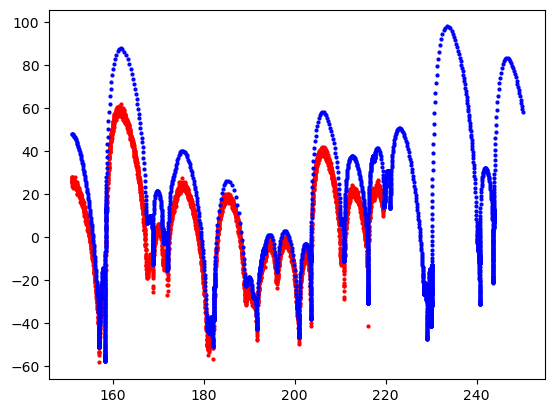

In [46]:
# Checking interpolation
plt.plot(time_uniform/24/3600/365,y_obs[0,:],label='Obs Uniform',color='r',linestyle='None',marker='o',markersize=2)
# plot with no line only with marker:
plt.plot(time_nonuniform/24/3600/365,X_full[:,0],label='Non-uniform',color='b',linestyle='None',marker='o',markersize=2)
#plt.xlim([160,180])

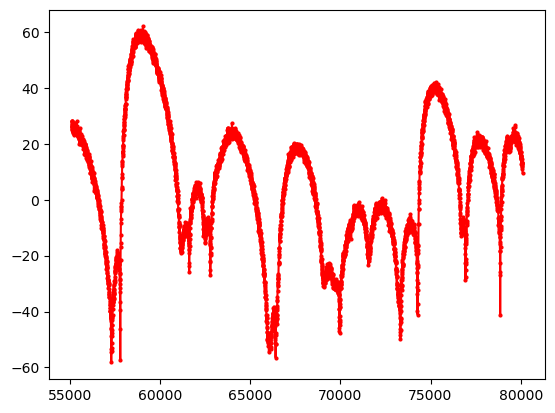

In [47]:
plt.plot(time_uniform[:]/24/3600,y_obs[0,:],label='Uniform',color='r',marker='o',markersize=2)


In [48]:
# Step 1: finding `X_uniform`, `time_uniform`


In [49]:
X_full.shape


(3613, 60)

In [50]:
y_obs.shape

(30, 5000)

In [51]:
# # To check the Obs_operator_nonlinear without the gaussian noise, you can use zero noise then the input and output of the function should be the same, except the input has theta as well, see this code that I am chekcing this function:
# alpha_f=np.random.randn(N_m,100,110)
# alph=alpha_f[:,0,1]
# alph_v=Obs_operator_nonlinear(alph,Obs_nonlinear_params)
# print(alph_v.reshape(N_m_v,)-alpha_f[:N_m_v,0,1])


In [52]:
# V_snapshot1 = U_ROM @ (alph[:N_m_v]) + q_bar_v.reshape(size,)
# V_snapshot2 = V_snapshot1.reshape(size_y, size_x)
# V_snapshot3 = 10**(V_snapshot2)
# V_snapshot3.shape

In [53]:
# Step by step checking the Obs_operator_nonlinear
# first checking the slip rate snapshot:


#### Checking nonlinear obs operator:
by applying to a real data and reconstructing back. 

uncomment things to check.

In [54]:
# # I need to load some of the already run models to check the scaling, after checking you can commentout this cell
# # Loading the data from the simulation
# # Loading data from "/central/groups/astuart/hkaveh/Data/LearnROM/"
# Tf = 250 # each initial condition is simulated for 250 years
# Nt=5     # it is recorded every Nt time stes
# N_m_load=30
# coeff=2 # How the inital conditions are from the chaotic attractor
# N_cut=2000
# filter_ratio=0.6 # removing 40 percent of the data
# # loading time series:
# number=0
# X_full=np.empty((1,N_m_load*2))
# data_dir="/central/groups/astuart/hkaveh/Data/LearnROM/SampleSimulation_Tf"+str(Tf)+"Nt="+str(Nt)+"N_m"+str(N_m_load)+"coeff"+str(coeff)+"number"+str(number)+".npz"
# data_smaple=np.load(data_dir)
# V_ox=data_smaple['array1']
# theta_ox=data_smaple['array2']
# t_ox=data_smaple['array3']
# # We work we log10 of V_ox:
# t=t_ox[:,0,0].reshape(-1,1)
# Start_index=0
# V_ox=np.log10(V_ox)
# theta_ox=np.log10(theta_ox)
# A_v,P_v=find_Aisv2_onlyv(U_v,V_ox,q_bar_v,N_m_load) # you dont need P in general, but I need it to check if I do everything correctly
# A_theta,P_theta=find_Aisv2_onlyv(U_theta,theta_ox,q_bar_theta,N_m_load)
# A=np.concatenate((A_v,A_theta),axis=1)
# X_onesimulation=A[Start_index:-1,:] # with removig the first 20 percent of the data to remove the transient
# X_full=np.append(X_full,X_onesimulation,axis=0)
# X_full=X_full[1:,:]
# # time_nonuniform=t[Start_index:-1,:]
# # print(X_full.shape)
# # print(time_nonuniform.shape)
# # t_0=time_nonuniform[0]
# # t_end=time_nonuniform[-1]
# days=int((t_end-t_0)/24/3600)
# index_delete=np.array([])
# if N_m_v<N_m_load:
#     index_delete=np.append(index_delete,np.arange(N_m_v,N_m_load))
# if N_m_theta<N_m_load:
#     index_delete=np.append(index_delete,np.arange(N_m_load+N_m_theta,2*N_m_load))


# # Convert the array elements to integers
# index_delete = index_delete.astype(int)

# X_full=np.delete(X_full,index_delete,axis=1)
# # print(X_full.shape)
# # print(time_nonuniform.shape)

In [55]:
# V_ox[Start_index:,:,:].shape

In [56]:
# X_full.shape

In [57]:
# # plotting the velocity field in 2D with colorbar
# plt.figure()
# plt.imshow(V_ox[Start_index+1,:,:],cmap='jet',vmin=-18,vmax=-6) # this is the first snapshot of the velocity field in log10
# plt.colorbar()


In [58]:

# # Obs_nonlinear_params=[U_ROM,q_bar_v,N_m_v,size,size_x,size_y,sigma_x,sigma_y,vpl]
# alpha=Obs_operator_nonlinear(X_full[0,:],Obs_nonlinear_params)
# V_snapshot1 = U_ROM @ (alpha[:N_m_v]) + q_bar_v.reshape(size,1)
# V_snapshot2 = V_snapshot1.reshape(size_y, size_x)


In [59]:
# V_snapshot2

In [60]:
# # plotting the velocity field in 2D with colorbar
# plt.figure()
# plt.imshow(V_snapshot2,cmap='jet',vmin=-18,vmax=-6) # this is the first snapshot of the velocity field in log10
# # colorbar with specific limits
# plt.colorbar()


In [61]:
H=np.append(np.eye(N_m_v,N_m_v),np.zeros((N_m_v,N_m_theta)),axis=1)

In [62]:
np.random.seed(0)
dump=xi_call(N_m,cov_matrix,1)
print(dump[0])
np.random.seed(0)

dump2=xi_call(N_m,cov_matrix,1)
print(dump2[0])
dump3=xi_call(N_m,cov_matrix,1)
print(dump3[0])

[-4.55955885]
[-4.55955885]
[2.38045786]


# EnKF

In [ ]:
# applying EnKF,
# The forward model is f and the observation operator is Obs_operator_linear
# The observation operator is linear and it is the first N_m_v components of the state
# start from m random initial conditions:
m=80

N_t=4000 # number of time units
alpha_f=np.empty((N_m,m,N_t))
alpha_a=np.empty((N_m,m,N_t))
# specifying random seed
np.random.seed(0)
alpha_a[:,:,0]=xi_call(N_m,Lambda,m) # initial conditions, every column is an ensemble member, The first analysis is the initial condition and is randomly selected based on the PDF of the chaotic attractor
Innovations=np.empty((N_m_v,m,N_t))
Obs_an=np.empty((N_m_v,m,N_t))      # Observation anomaly 
Obs=np.empty((N_m_v,m,N_t))         # Observation
for k in range(N_t-1):
    print(k)
    # forecast step:
    for i in range(m):
        alpha_f[:,i,k+1]=f(alpha_a[:,i,k],dt,params_f)[0][:,-1] + xi_call(N_m,cov_matrix,1).reshape(N_m,) # this is the forecast ,[0] is to not consider time and -1 is to take the last time step
    # finding Kalman gain:
    alpha_bar=np.mean(alpha_f[:,:,k+1],axis=1).reshape(N_m,1) # this is the mean of the forecast with adding one dimension
    # anomaly matrix:
    A_f=(alpha_f[:,:,k+1]-alpha_bar)/np.sqrt(m-1)
    # covariance matrix of the forecast:
    P_f=np.dot(A_f,A_f.T)
    # Kalman gain:
    if Obs_linear==1:
        K=scipy.linalg.solve(np.dot(H,np.dot(P_f,H.T))+gamma_ratio*Gamma,np.dot(H,P_f)).T
        # analysis step:
        for i in range(m):
            alpha_a[:,i,k+1]=alpha_f[:,i,k+1]+np.matmul(K,y_obs[:,k+1].reshape(-1,1)-Obs_operator_linear(alpha_f[:,i,k+1])).reshape(N_m,)
            Innovations[:,i,k+1]=y_obs[:,k+1]-Obs_operator_linear(alpha_f[:,i,k+1]).reshape(-1)
    else:
        # finding the observation anomaly matrix:
        for i in range(m):
            Obs[:,i,k+1]=Obs_operator_nonlinear(alpha_f[:,i,k+1],Obs_nonlinear_params).reshape(N_m_v,) # h(\alpha^{f,i}) in the paper
        
        etas=eta_call(Gamma,gamma_ratio,m) # This function makes noise with shape N_m_v* m, each column is one noise for one ensemble member
        mean_obs=np.mean(Obs[:,:,k+1],axis=1) # this is the mean of the observation (denoted by \bar z in Jeff's paper) or \bar y^f in my paper, has the shape (N_m_v,)
        mean_eta=np.mean(etas,axis=1) # this is the mean of the observation noise (denoted by \bar v in Jeff's paper) or \bar \eta in my paper , has the shape (N_m_v,)

        Obs_an[:,:,k+1]=(Obs[:,:,k+1]-mean_obs[:,np.newaxis]-etas+mean_eta[:,np.newaxis])/np.sqrt(m-1) # This is matrix Z i Jeff's paper or Y in my paper
        # Finding Kalman gain:
        K=scipy.linalg.solve(Obs_an[:,:,k+1]@Obs_an[:,:,k+1].T,Obs_an[:,:,k+1]@A_f.T).T       
        # analysis step:
        for i in range(m):
            alpha_a[:,i,k+1]=alpha_f[:,i,k+1]+np.matmul(K,y_obs[:,k+1]-Obs[:,i,k+1])     
            Innovations[:,i,k+1]=y_obs[:,k+1]-Obs[:,i,k+1]
            
        

0


### Postprocessing EnKF

In [60]:
time=np.linspace(0,N_t*dt,N_t)

In [61]:
mean_a=np.mean(alpha_a,axis=1)


(0.0, 50.0)

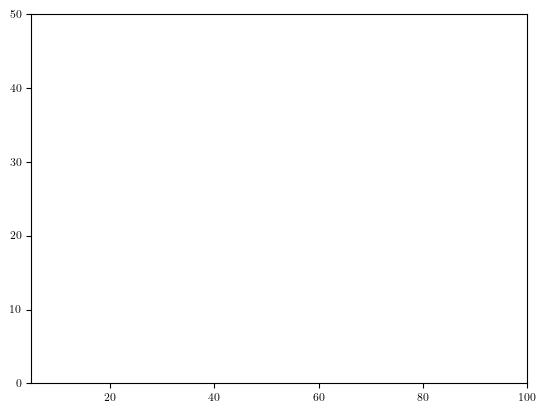

In [62]:
for i in range(m):
    plt.plot(time/3600/24,alpha_a[0,i,:],color='b',alpha=0.1)
plt.plot(time/3600/24,y_obs[0,:N_t],label='Observation',color='r')
plt.xlim([5,100])
plt.ylim([0,50])

(-50.0, 50.0)

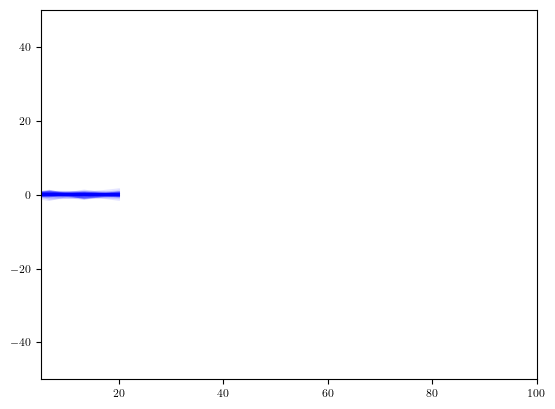

In [63]:
# plotting the time series of innovations
for i in range(m):
    plt.plot(time/3600/24,Innovations[0,i,:],color='b',alpha=0.1)
plt.xlim([5,100])
plt.ylim([-50,50])

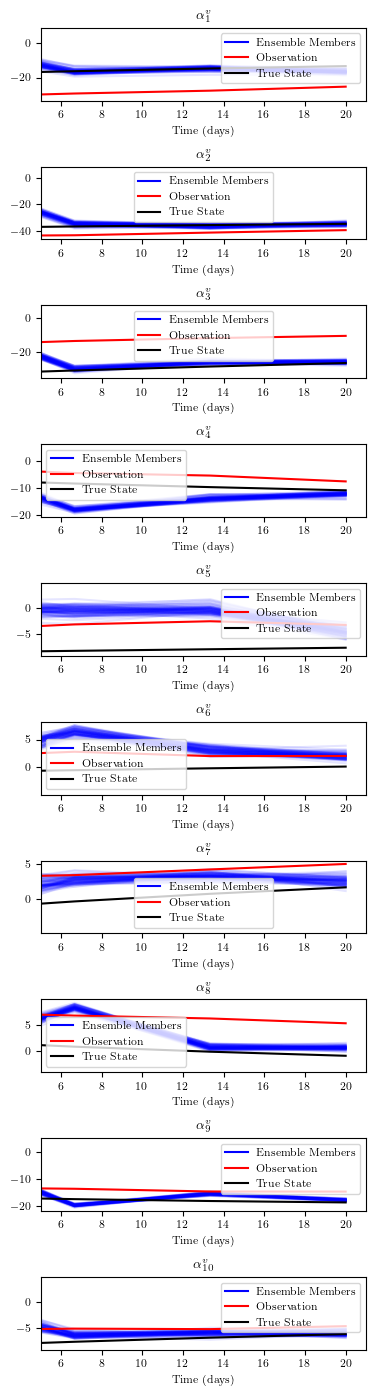

In [64]:
# Postprocessing and plotting the the behavior of the EnKF
# One natural figure to think of is plotting the first four dims of observation and the first four dims of the EnKF for all members
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'text.usetex': True,  # If you want to use LaTeX for rendering text
})

fig, axs = plt.subplots(10, 1, figsize=(3.8, 14))
# adjust the font size for anything in this figure

# Flatten the axs array so that we can iterate over it easily
axs = axs.flatten()
plt.rcParams.update({'font.family': 'serif', 'font.serif': 'Times New Roman','font.size': 8})

# Plot the KDE plot for each column of X_full
for i in range(10):
    for j in range(m-1):
        axs[i].plot(time/3600/24,alpha_a[i,j,:],color='b',alpha=0.1)
    axs[i].plot(time/3600/24,alpha_a[i,-1,:],color='b',alpha=0.1,label='Ensemble Members')
    axs[i].plot(time/3600/24,y_obs[i,:N_t],label='Observation',color='r')
    axs[i].plot(time/3600/24,X_uniform[:N_t,i],label='True State',color='k')
    axs[i].set_title(r'$\alpha^v_{{{}}}$'.format(i+1))
    axs[i].set_xlim(left=5)
    axs[i].legend(ncol=2)
    axs[i].set_xlabel('Time (days)')
    leg = axs[i].legend()
    for lh in leg.legendHandles:
          lh.set_alpha(1)

# Adjust layout and show plot
plt.tight_layout()
plt.show()
# save the figure in the central directory
#fig.savefig("/central/groups/astuart/hkaveh/Figs/ROM/draft_EnKF_vel"+"4.pdf", bbox_inches='tight')


In [65]:
alpha_a.shape

(40, 80, 4)

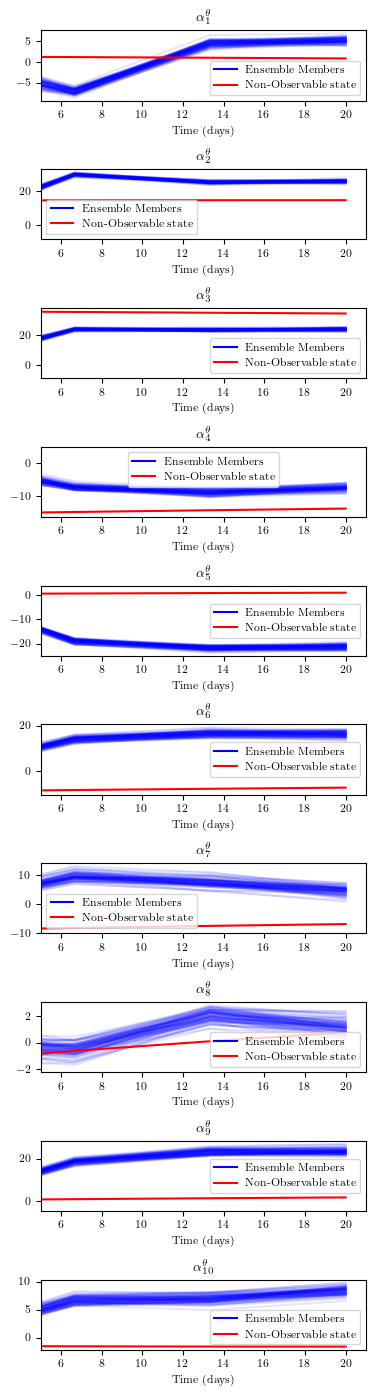

In [66]:
# Postprocessing and plotting the the behavior of the EnKF
# One natural figure to think of is plotting the first four dims of observation and the first four dims of the EnKF for all members
theta_data=X_uniform[:,N_m_v:].T
fig, axs = plt.subplots(10, 1, figsize=(3.8, 14))

# Flatten the axs array so that we can iterate over it easily
axs = axs.flatten()

# Plot the KDE plot for each column of X_full
for i in range(10):
    for j in range(m-1):
        axs[i].plot(time/3600/24,alpha_a[i+N_m_v,j,:],color='b',alpha=0.1)
    axs[i].plot(time/3600/24,alpha_a[i+N_m_v,-1,:],color='b',alpha=0.1,label='Ensemble Members')
    axs[i].plot(time/3600/24,theta_data[i,:N_t],label='Non-Observable state',color='r')
    axs[i].set_title(r'$\alpha^\theta_{{{}}}$'.format(i+1))
    axs[i].set_xlim(left=5)
    axs[i].legend(ncol=2)
    axs[i].set_xlabel('Time (days)')
    leg = axs[i].legend()
    for lh in leg.legendHandles:
          lh.set_alpha(1)

# Adjust layout and show plot
plt.tight_layout()
plt.show()
# save the figure in the central directory
#fig.savefig("/central/groups/astuart/hkaveh/Figs/ROM/draft_EnKF_theta"+"4.pdf", bbox_inches='tight')




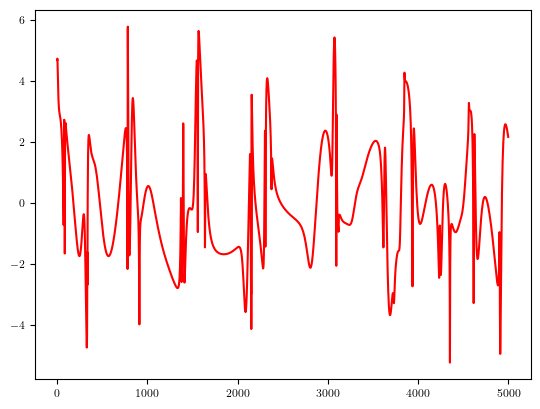

In [67]:
theta_data.shape
plt.plot(theta_data[-1,:],label='Non-Observable state',color='r')

## Double checking EnKF
To do:

* read the equations and check everything from scratch (done).

* plot the innovation

* run it for bigger time steps with bigger noise


# Saving the output

What do you want to save?
* Observation
* forecast step
* analysis step
* Data without noise


In [ ]:
# saving different data in one file
# you can have everything in this very one line of code:
# alpha_a,alpha_f,Innovations,time,y_obs[:,:N_t],X_uniform[:N_t,:]
np.savez("/central/groups/astuart/hkaveh/Data/LearnROM/EnKF_N_m_v"+str(N_m_v)+"N_m_theta"+str(N_m_theta)+"Obs_linear"+str(Obs_linear)+"N_t"+str(N_t)+"m"+str(m)+"sigma_kernel"+str(sigma_kernel)+"gamma_ratio"+str(gamma_ratio)+"version"+str(version)+"NumberinDataset"+str(number),alpha_a=alpha_a,alpha_f=alpha_f,Innovations=Innovations,time=time,y_obs=y_obs[:,:N_t],X_uniform=X_uniform[:N_t,:],t_0=t_0,number=number)

